# Brain Tumor Classification - Baseline CNN Model

This notebook implements a baseline CNN model for brain tumor classification using PyTorch. We'll use the preprocessed brain tumor MRI dataset to train and evaluate a simple CNN architecture.

## 1. Setup and Imports

In [1]:
# Standard library imports
import os
import pathlib
from typing import Tuple, Dict, List

# Data processing and visualization
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Dataset
import kagglehub

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 2. Data Loading and Preprocessing

In [3]:
def setup_data(batch_size: int = 64) -> Tuple[DataLoader, DataLoader, torchvision.datasets.ImageFolder, torchvision.datasets.ImageFolder]:
    """
    Set up data loaders and datasets for training and validation.

    Args:
        batch_size: Number of samples per batch

    Returns:
        train_loader: DataLoader for training
        val_loader: DataLoader for validation
        train_set: Training dataset
        val_set: Validation dataset
    """
    # Download dataset
    path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
    data_dir = pathlib.Path(path)

    # Define transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((128,128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Create datasets
    train_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Training'),
        transform=transform
    )
    val_set = torchvision.datasets.ImageFolder(
        data_dir.joinpath('Testing'),
        transform=transform
    )

    # Create data loaders
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f'Training samples: {len(train_set)}')
    print(f'Validation samples: {len(val_set)}')
    print(f'Number of classes: {len(train_set.classes)}')
    print(f'Classes: {train_set.classes}')

    return train_loader, val_loader, train_set, val_set

# Set up data loaders
train_loader, val_loader, train_set, val_set = setup_data(batch_size=64)

Training samples: 5712
Validation samples: 1311
Number of classes: 4
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## 3. Model Architecture

In [4]:
class BrainTumorCNN(nn.Module):
    """
    CNN architecture for brain tumor classification.

    Architecture:
    - 4 convolutional blocks (each with Conv2d, BatchNorm2d, LeakyReLU, MaxPool2d)
    - 2 fully connected layers with dropout
    """
    def __init__(self, num_classes: int = 4):
        super(BrainTumorCNN, self).__init__()

        # Convolutional layers
        self.features = nn.Sequential(
            # First conv block
            nn.Conv2d(1, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Second conv block
            nn.Conv2d(16, 32, kernel_size=5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Third conv block
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            # Fourth conv block
            nn.Conv2d(64, 128, kernel_size=5),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 1024),
            nn.LeakyReLU(),
            nn.Dropout(0.5),  # Add dropout to prevent overfitting
            nn.Linear(1024, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

# Initialize model
model = BrainTumorCNN().to(device)
print(model)

BrainTumorCNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

## 4. Training Functions

In this section, we define our training and visualization functions. The `train_model` function handles the training loop, validation, and metrics collection, while `plot_training_history` helps visualize the training progress.



In [5]:
def train_model(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    num_epochs: int = 10,
    learning_rate: float = 0.001,
) -> Dict[str, List[float]]:
    """
    Train the model and return training history.

    Args:
        model: PyTorch model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        num_epochs: Number of training epochs
        learning_rate: Initial learning rate

    Returns:
        Dictionary containing training history
    """
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    history = {
        'train_loss': [],
        'val_loss': [],
        'accuracy': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate metrics
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        accuracy = 100 * correct / total

        # Update learning rate
        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%')

    return history

## 5. Model Training and Evaluation

Here we initialize our model, loss function, optimizer, and learning rate scheduler. We then train the model using our defined training function.



In [6]:
# Train the model
model = BrainTumorCNN().to(device)
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

Epoch 1/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/10:
Train Loss: 0.8802, Val Loss: 0.6941, Accuracy: 72.92%


Epoch 2/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 2/10:
Train Loss: 0.4586, Val Loss: 0.6251, Accuracy: 75.29%


Epoch 3/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 3/10:
Train Loss: 0.3470, Val Loss: 0.5035, Accuracy: 79.18%


Epoch 4/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 4/10:
Train Loss: 0.2904, Val Loss: 0.2808, Accuracy: 88.71%


Epoch 5/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 5/10:
Train Loss: 0.2322, Val Loss: 0.3446, Accuracy: 87.19%


Epoch 6/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 6/10:
Train Loss: 0.1874, Val Loss: 0.2654, Accuracy: 90.01%


Epoch 7/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 7/10:
Train Loss: 0.1554, Val Loss: 0.1668, Accuracy: 93.44%


Epoch 8/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 8/10:
Train Loss: 0.1237, Val Loss: 0.1488, Accuracy: 93.44%


Epoch 9/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 9/10:
Train Loss: 0.1266, Val Loss: 0.2194, Accuracy: 92.60%


Epoch 10/10:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 10/10:
Train Loss: 0.0887, Val Loss: 0.1589, Accuracy: 94.13%


## 6. Visualizing Results

We visualize the training and validation metrics to understand how our model performs over time. This includes:
- Training and validation loss curves
- Validation accuracy progression

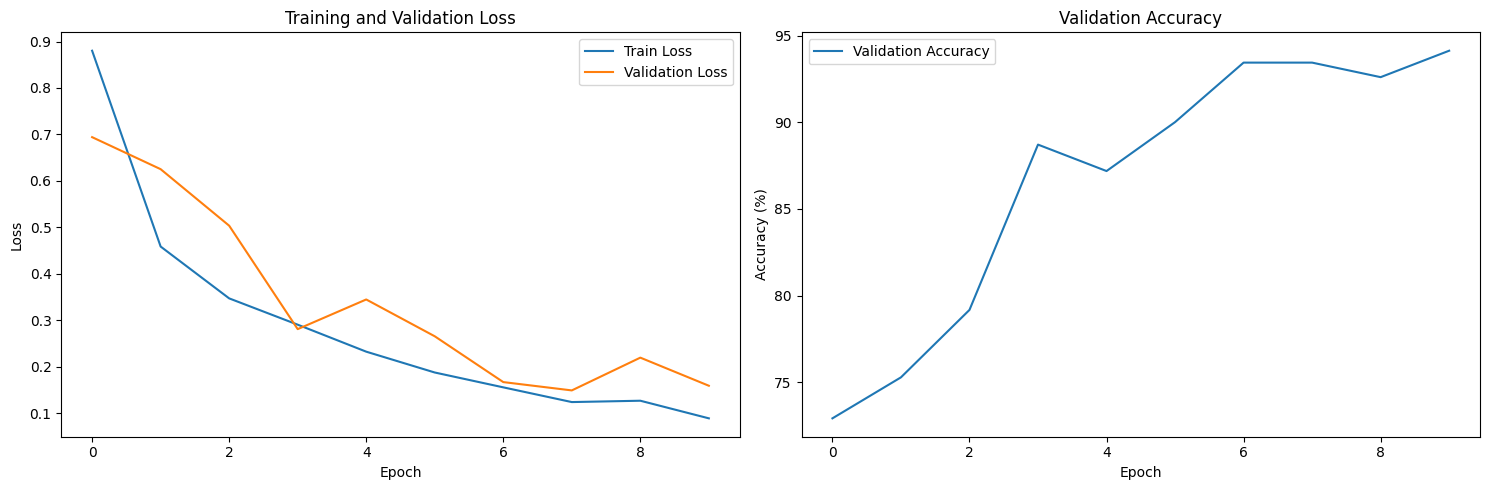

In [7]:
def plot_training_history(history: Dict[str, List[float]]):
    """Plot training metrics."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['accuracy'], label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

## 7. Model Testing and Visualization

In this section, we test our model on individual images from the validation set and visualize the results. This helps us understand how the model performs on specific examples.

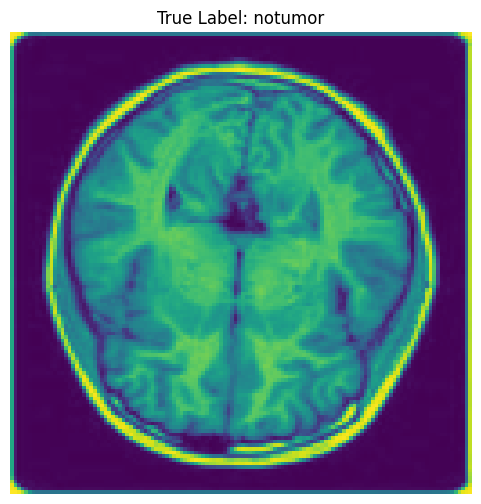

Predicted Class: notumor


In [8]:
def predict_single_image(model: nn.Module, image: torch.Tensor, classes: List[str]) -> str:
    """
    Make prediction for a single image.

    Args:
        model: Trained PyTorch model
        image: Input image tensor
        classes: List of class names

    Returns:
        Predicted class name
    """
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, pred = torch.max(output, 1)
        return classes[pred.item()]



# Example prediction
sample_idx = 1000
img, label = val_set[sample_idx]
plt.figure(figsize=(6, 6))
plt.imshow(img.permute(1, 2, 0))
plt.title(f'True Label: {val_set.classes[label]}')
plt.axis('off')
plt.show()

predicted_class = predict_single_image(model, img, val_set.classes)
print(f'Predicted Class: {predicted_class}')